# Evolution of Online Communication in Non-Monogamous Romantic Relationships
## An Analysis of WhatsApp Messages

This study explores how the frequency, topic, and sentiment of WhatsApp messages evolve
throughout non-monogamous romantic relationships. The aim is to analyze how communication
dynamics may reflect changes in the relationship. The methodology includes analyzing WhatsApp
messages from a group of participants in non-monogamous relationships, using text analysis
techniques to identify themes and sentiments.

# Import

Libraries used:

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors #custom cmap
import re
import emoji
import numpy as np
import nltk
import wordcloud


from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from polyglot.detect import Detector
from tqdm import tqdm
from getpass import getpass
from collections import Counter
from pprint import pprint

# Preparing data

## Parsing txt files

The WhatsApp chat back up TXT files are parsed, extracting contact, timestamp and message content loading each message as a row of a pandas DataFrame.

For each contact, resulting dataframes are saved into CSV files.

In [3]:
# Function to parse the WhatsApp chat
def parse_whatsapp_chat(file_path):
    messages = []
    current_message = None  # To hold the current message being built

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Regex to match the WhatsApp message format
            match = re.match(r'(\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}) - (.*?): (.*)', line)
            if match:
                # If we have a current message, save it before starting a new one
                if current_message:
                    messages.append(current_message)

                # Start a new message
                date_time = match.group(1)
                sender = match.group(2)
                message = match.group(3)
                current_message = {'date_time': date_time, 'sender': sender, 'message': message}
            elif current_message:
                # If the line doesn't match, append it to the current message
                current_message['message'] += ' ' + line.strip()  # Append the new line to the current message

    # Add the last message if it exists
    if current_message:
        messages.append(current_message)

    return messages

In [125]:
contacts = ['FREYA', 'AFRODITA', 'PACHAMAMA', 'CERES', 'ISIS', 'AMATERASU', 'ISHTAR', 'KALI', 'BRIGID',
            'CLIO', 'EUTERPE', 'CALLIOPE', 'ERATO', 'TERPSICHORE', 'POLYHYMNIA', 'MELPOMENE']

In [5]:
phone = getpass('Insert own phone: ')
myself = 'ME'
input_folder = 'private/txt'
output_folder = 'private/parsed_csv'


for contact in contacts:
    chat_data = parse_whatsapp_chat(f"{input_folder}/{contact}.txt")
    df = pd.DataFrame(chat_data)

    # Create timestamp from date_time column
    df['timestamp'] = pd.to_datetime(df['date_time'], format='%m/%d/%y, %H:%M')
   
    # Make sure the contact name is consistent along the conversation
    df['sender'] = df['sender'].apply(lambda x: myself if x == phone else contact)
    # Create the receiver column
    df['receiver'] = df['sender'].apply(lambda x: contact if x == myself else myself)

    df['contact'] = contact
    
    df[['contact', 'timestamp', 'sender', 'receiver', 'message']].to_csv(f"{output_folder}/{contact}.csv", index=False)
    print(f"Parsed chat {output_folder}/{contact}.csv was saved!")
  

Insert own phone:  ········


Parsed chat private/parsed_csv/FREYA.csv was saved!
Parsed chat private/parsed_csv/AFRODITA.csv was saved!
Parsed chat private/parsed_csv/PACHAMAMA.csv was saved!
Parsed chat private/parsed_csv/CERES.csv was saved!
Parsed chat private/parsed_csv/ISIS.csv was saved!
Parsed chat private/parsed_csv/AMATERASU.csv was saved!
Parsed chat private/parsed_csv/ISHTAR.csv was saved!
Parsed chat private/parsed_csv/KALI.csv was saved!
Parsed chat private/parsed_csv/BRIGID.csv was saved!
Parsed chat private/parsed_csv/CLIO.csv was saved!
Parsed chat private/parsed_csv/EUTERPE.csv was saved!
Parsed chat private/parsed_csv/CALLIOPE.csv was saved!
Parsed chat private/parsed_csv/ERATO.csv was saved!
Parsed chat private/parsed_csv/TERPSICHORE.csv was saved!
Parsed chat private/parsed_csv/POLYHYMNIA.csv was saved!
Parsed chat private/parsed_csv/MELPOMENE.csv was saved!


## Concat chats into chat DataFrame

'chat' DataFrame will hold all the messages from all the contacts analysed. Message-related columns calculated will be added to this DataFrame.

In [6]:
input_folder = "private/parsed_csv"
start_date = '2020-01-01'
end_date = '2025-01-01'

chat_dict = {}

for contact in contacts:
    df = pd.read_csv(f"{input_folder}/{contact}.csv")
    df = df.dropna(subset=['message'])
    df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
    # Dictionary that holds a DataFrame for each chat
    chat_dict[contact] = df

chat = pd.concat(chat_dict.values(), ignore_index=True)
chat = chat.sort_values(by='timestamp', ignore_index=True)

In [7]:
print("Messages\tContact")
print("-"*30)
for each in chat_dict.keys():
    print(f"{len(chat_dict[each])}\t\t{each}")

Messages	Contact
------------------------------
80624		FREYA
21346		AFRODITA
15263		PACHAMAMA
13113		CERES
12458		ISIS
11166		AMATERASU
11030		ISHTAR
10525		KALI
6485		BRIGID
4157		CLIO
3470		EUTERPE
3384		CALLIOPE
1942		ERATO
1454		TERPSICHORE
1216		POLYHYMNIA
898		MELPOMENE


In [8]:
# chat.to_pickle('private/chat10.pkl')

In [265]:
# chat = pd.read_pickle('private/chat10.pkl') 

***

## Calculating columns for analysis (I)

From the inital columns, the following will be calculated:

### _message_id_

A unique identifier for each message in the chat DataFrame.

In [266]:
chat.reset_index(drop=True, inplace=True)
chat['message_id'] = chat.index + 1

### _year_month_

Year and month in which the message was sent.

In [267]:
chat.timestamp = pd.to_datetime(chat.timestamp)

chat['year_month'] = chat['timestamp'].dt.strftime('%Y-%m')

### _year_week_

Year and week in which the message was sent. Will be useful for grouping when doing analysis on weekly level.

In [268]:
chat.timestamp = pd.to_datetime(chat.timestamp)

chat['year_week'] = chat['timestamp'].dt.isocalendar().apply(lambda x: f"{x['year']}-W{x['week']}", axis=1)

### _message_type_

WhatsApp messages can be text, or media (including voicenotes, animated GIFs, pictures, etc.)
A message can be deleted after sending, but the existance of a deleted message is logged.

In [269]:
def classify_message_type(message):
    if "<Media omitted>" in message:
        return "media"
    elif ("This message was deleted" in message) or ("You deleted this message" in message):
        return "deleted"
    else:
        return "message"


chat['message_type'] = chat['message'].apply(classify_message_type)

In [275]:
message_type_counts = pd.DataFrame(chat.message_type.value_counts())

### _media_ratio_

Ratio of media messages sent in respect to the total amount of messages of any type sent by month.

In [13]:
# Calculate the monthly media_ratio per contact
chat['media_ratio'] = chat.groupby(['contact', 'year_month'])['message_type'].transform(lambda x: (x == 'media').sum() / len(x))

### create topic dataframe

A simplified copy of the chat DataFrame is made, to be used later in topic analysis.

In [14]:
topic = chat.loc[chat.message_type=='message', ['contact', 'message_id', 'message', 'year_month', 'year_week']]

In [15]:
# topic.to_pickle('private/topic10.pkl')

## Extract info from message content

All the messages not being text are filtered out.

In [16]:
messages = chat[chat.message_type=='message']

### Emoji

A copy of 'messages' is made for emoji use analysis.

In [17]:
emoji_df = messages.copy()

#### emoji counter

Calculates for each message the total number of emoji used.

In [18]:
def count_emojis(text):
    # Count the number of emojis in the message
    return sum(1 for char in text if emoji.is_emoji(char))

emoji_df['emoji_count'] = emoji_df.message.apply(count_emojis)

#### extract emoji

Extract all the emoji used in each message, without repetitions. Will be used to calculated top monthly/weekly emojis.

In [19]:
def extract_unique_emojis(text):
    # Create a set to store unique emojis
    unique_emojis = set()
    
    # Use emoji.emoji_list to get a list of all emojis in the text
    for em in emoji.emoji_list(text):
        unique_emojis.add(em['emoji'])
    
    # Join the unique emojis into a single string
    return ''.join(unique_emojis)


emoji_df['emoji'] = emoji_df.message.apply(extract_unique_emojis)

### create emoji dataframe

In [20]:
emoji_df = emoji_df[['message_id', 'contact', 'timestamp', 'sender', 'emoji', 'emoji_count', 'year_month','year_week']]

emoji_df = emoji_df[emoji_df.emoji_count>0]

In [21]:
# emoji_df.to_pickle("public/emoji10.pkl")

### chunking

Both **language detection** and **sentiment analysis** prove difficult on very short messages since the tools used to determine them rely on context. **chunks** (i.e. groups of messages) are made from up to 300 characters to improve performance.

In [22]:
# Function to process each chunk
def process_chunk(chunk):
    return chunk

# Function to create message chunks
def create_message_chunks(df):
    chunks = []
    indices = []
    
    for (name, month), group in df.groupby(['contact', 'year_month']):
        current_chunk = ""
        current_indices = []
        
        for idx, row in group.iterrows():
            message = row['message']
            if len(current_chunk) + len(message) + 1 <= 300:  
                current_chunk += (message + " ")
                current_indices.append(idx)
            else:
                # Process the current chunk
                processed_value = process_chunk(current_chunk.strip())
                chunks.append(processed_value)
                indices.append(current_indices)
                
                # Start a new chunk
                current_chunk = message + " "
                current_indices = [idx]
        
        # Process any remaining messages in the last chunk
        if current_chunk:
            processed_value = process_chunk(current_chunk.strip())
            chunks.append(processed_value)
            indices.append(current_indices)
    
    return chunks, indices

In [23]:
# Create chunks and get indices
chunks, indices = create_message_chunks(messages)

# Create a new column in the original DataFrame for processed values
messages['chunk'] = None

# Assign processed values to the corresponding rows
for chunk, idx_list in zip(chunks, indices):
    for idx in idx_list:
        messages.at[idx, 'chunk'] = chunk

# Only keep first row for each chunk
messages['chunk'] = messages['chunk'].where(~messages['chunk'].duplicated(), other=None)


### sentiment

A subset of the chat dataframe is prepared to be processed by the sentiment analysis model.

In [ ]:
sentiment_df = messages[['message_id', 'chunk']]

#### transformers sentiment analysis

Hugging Face's _transformers_ pre-trained sentiment-analysis pipeline is used on top on multilingual bert since there are messages in a variety of languages (mostly Spanish, Catalan and English). 

Each chunk of text is assigned a polarity (from 1 to 5) assessing sentiment. A confidence value from 0 to 1 is returned along every polarity, indicating how sure the model is about the polarity value calculated. 

In [ ]:
def analyze_sentiment_multilingual(message):
    if not hasattr(analyze_sentiment_multilingual, "sentiment_pipeline"):
        # Load the multilingual sentiment analysis model once
        analyze_sentiment_multilingual.sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

    # Truncate the message if it exceeds 512 characters
    if len(message) > 512:
        message = message[:512]
    
    # Analyze sentiment 
    sentiment = analyze_sentiment_multilingual.sentiment_pipeline(message)[0]  # Get the first result

    # Mapping of labels to adjusted values
    label_mapping = {
        '1 star': 1,  # Very Negative
        '2 stars': 2,  # Negative
        '3 stars': 3,   # Neutral
        '4 stars': 4,   # Positive
        '5 stars': 5    # Very Positive
    }
    
    return (label_mapping[sentiment['label']], sentiment['score'])

#### _sa_polarity_ and _sa_adjusted_

The column _sa_adjusted_ is obtained by multiplying polarity and confidence, giving more relevance to polarities with a bigger confidence index.

In [ ]:
tqdm.pandas() # activates tqdm progess_apply to follow the progress of long processes

def chunk_sentiment(chunk):
    if chunk == None: return (np.nan,np.nan)
    else: return analyze_sentiment_multilingual(chunk)

sentiment_df['chunk_sentiment'] = sentiment_df['chunk'].progress_apply(chunk_sentiment)

sentiment_df[['sa_polarity', 'sa_certainty']] = sentiment_df['chunk_sentiment'].apply(pd.Series)

sentiment_df['sa_adjusted'] = sentiment_df.sa_polarity * sentiment_df.sa_certainty

### happiness

Finally, "happiness" is calculated by removing the outliers from _sa_certainty_ and normalizing the remaining values into a percentage, 
obtaining values from 0% to 100%.

In [ ]:
# Step 1: Identify outliers using IQR
Q1 = sentiment_df['sa_adjusted'].quantile(0.25)
Q3 = sentiment_df['sa_adjusted'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 2: Create the happiness column
sentiment_df['happiness'] = np.where(
    (sentiment_df['sa_adjusted'] < lower_bound) | (sentiment_df['sa_adjusted'] > upper_bound),
    np.nan,
    (sentiment_df['sa_adjusted'] - lower_bound) / (upper_bound - lower_bound) * 100
)

# Normalize only the non-outlier values
min_value = sentiment_df['sa_adjusted'][sentiment_df['happiness'].notna()].min()
max_value = sentiment_df['sa_adjusted'][sentiment_df['happiness'].notna()].max()

sentiment_df['happiness'] = np.where(
    sentiment_df['happiness'].notna(),
    (sentiment_df['sa_adjusted'] - min_value) / (max_value - min_value) * 100,
    np.nan
)

In [ ]:
# sentiment_df.to_pickle('private/sentiment10.pkl')

In [26]:
# sentiment_df = pd.read_pickle('private/sentiment10.pkl')

In [27]:
chat = chat.merge(sentiment_df, on='message_id', how='left')

In [28]:
chat = chat[['message_id', 'contact', 'timestamp', 'sender', 'sa_polarity', 'happiness', 'media_ratio', 'year_month', 'year_week']]

### _language_

Language detection is made using the library _polyglot_. A list of possible most used languages is given. If a message language appear not fo fall inside the possible languages, it is marked as 'not sure'.

In [29]:
language_df = messages[['message_id', 'chunk']]

In [30]:
def detect_language_polyglot(text):
    possible_languages = ['es','ca','en','it']
    try:
        detector = Detector(text)
        for language in detector.languages:
            if language.code in possible_languages:
                return language.code
        return 'not sure'
    except:
        return 'not sure'

In [ ]:
language_df['language'] = language_df['chunk'].apply(lambda x: detect_language_polyglot(x) if pd.notna(x) else x) 

In [32]:
chat = chat.merge(language_df, on='message_id', how='left')

In [33]:
chat = chat[['message_id', 'contact', 'timestamp', 'sender', 'sa_polarity', 'happiness', 'media_ratio', 'language', 'year_month', 'year_week']]

## Calculating columns (II)

### _waiting time_
Time elapsed since last message for each contact.

In [34]:
# Convert the 'timestamp' column to datetime
chat['timestamp'] = pd.to_datetime(chat['timestamp'])

# Calculate the time elapsed since the last message of the same person
chat['waiting_time'] = chat.groupby('contact')['timestamp'].diff()

# Fill NaN values with 0
chat['waiting_time'] = chat['waiting_time'].fillna(pd.Timedelta(seconds=0))

### _month_share_
Messages exchanged for each contact divided by the total number os messages exchanged (monthly granularity)

In [35]:
# Count messages per contact per month
message_counts = chat.groupby(['year_month','contact']).size().reset_index(name='message_count')

# Calculate total messages per month
total_messages_month = message_counts.groupby(['year_month']).message_count.sum().reset_index(name='total_messages_month')

# Merge total messages back to the message counts
message_counts = message_counts.merge(total_messages_month, on='year_month')

# Calculate MONTHLY_SHARE
message_counts['month_share'] = message_counts['message_count'] / message_counts['total_messages_month']

# Merge back into chat DataFrame
chat = chat.merge(message_counts[['year_month', 'contact', 'month_share']], on=['year_month', 'contact'], how='left')

### _week_share_
Same as _month_share_ but for a week span of time.

In [36]:
message_counts = chat.groupby(['year_week','contact']).size().reset_index(name='message_count')

total_messages_week = message_counts.groupby(['year_week']).message_count.sum().reset_index(name='total_messages_week')

message_counts = message_counts.merge(total_messages_week, on='year_week')

message_counts['week_share'] = message_counts['message_count'] / message_counts['total_messages_week']

chat = chat.merge(message_counts[['year_week', 'contact', 'week_share']], on=['year_week', 'contact'], how='left')

### _month_enm_
Number of active conversations for each month period.

In [37]:
# Create a new column for the number of unique contacts per year_month
chat['m_enm'] = chat.groupby('year_month')['contact'].transform(lambda x: x.nunique())

### _week_enm_
Number of active conversations for each week period.

In [38]:
# Create a new column for the number of unique contacts per year_week
chat['w_enm'] = chat.groupby('year_week')['contact'].transform(lambda x: x.nunique())

### _stage_
Indicates the position of the messages along the line of the social interaction from beginning to the end. i.e. for year long interaction, first message is given a 0% a message sent 6 months after will get a 50%, etc

Useful for normalizing the duration of all interactions.

In [ ]:
# Sort the DataFrame by 'timestamp' to ensure chronological order
chat = chat.sort_values(by='timestamp')

# Function to calculate time position percentage
def calculate_stage(group):
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    total_time = end_time - start_time
    
    # Calculate the percentage position in time for each message
    group['stage'] = ((group['timestamp'] - start_time) / total_time) * 100
    return group

# Apply the function to each group
chat = chat.groupby('contact').apply(calculate_stage)

# Sort the DataFrame back to the original order by timestamp
chat = chat.sort_values(by='timestamp')

# Reset index to clean up the DataFrame
chat.reset_index(drop=True, inplace=True)


### _uptime_
Days elapsed since the first message exchanged.

In [ ]:
# Function to calculate uptime
def calculate_uptime(group):
    first_time = group['timestamp'].min()
    group['uptime'] = group['timestamp'] - first_time
    return group

# Apply the function to each group
chat = chat.groupby('contact').apply(calculate_uptime)

# Sort the DataFrame back to the original order by timestamp
chat = chat.sort_values(by='timestamp')

# Reset index to clean up the DataFrame
chat.reset_index(drop=True, inplace=True)

# Convert timedelta to number of complete days as integers
chat['uptime'] = chat['uptime'].dt.days


### _message_position_
counter of messages for each contact. (cumulative count)

In [41]:
# Create a new column for the position of each message inside contact group
chat['message_position'] = chat.groupby('contact').cumcount()


### _ended_
Indicates if the message exchange has a continuity for each contact after 31 Dec 2024 (end of the period analysed)

In [42]:
# List of ongoing chats
ongoing_chats = ['FREYA', 'AFRODITA']

# Create the 'ended' column
chat['ended'] = chat['contact'].apply(lambda x: x not in ongoing_chats)

In [43]:
# chat.to_pickle('public/chat20.pkl')

# ANALYSIS

In [300]:
# chat = pd.read_pickle('public/chat20.pkl')

In [301]:
chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198531 entries, 0 to 198530
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   message_id        198531 non-null  int64          
 1   contact           198531 non-null  object         
 2   timestamp         198531 non-null  datetime64[ns] 
 3   sender            198531 non-null  object         
 4   sa_polarity       25632 non-null   float64        
 5   happiness         23942 non-null   float64        
 6   media_ratio       198531 non-null  float64        
 7   language          25632 non-null   object         
 8   year_month        198531 non-null  object         
 9   year_week         198531 non-null  object         
 10  waiting_time      198531 non-null  timedelta64[ns]
 11  month_share       198531 non-null  float64        
 12  week_share        198531 non-null  float64        
 13  m_enm             198531 non-null  int64    

## Time analysis

### time of the day

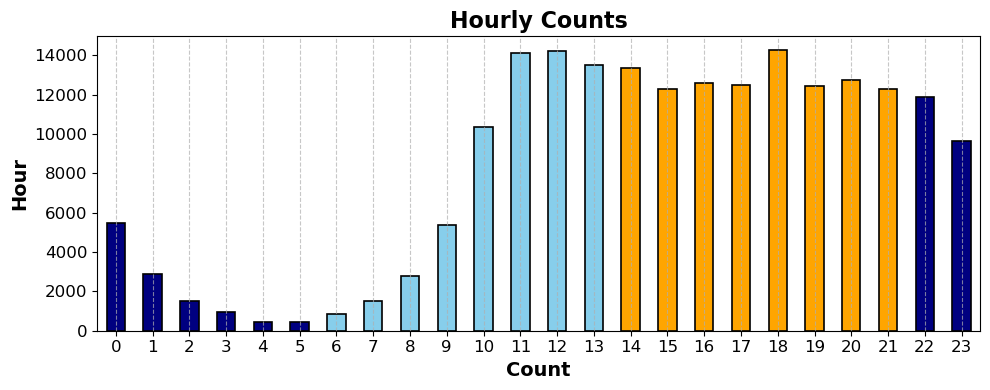

In [114]:
# Count the occurrences of each hour
hour_counts = chat['timestamp'].dt.hour.value_counts().sort_index(ascending=True)

# Define colors for each hour
colors = []
for hour in hour_counts.index:
    if hour in [22, 23, 0, 1, 2, 3, 4, 5]:
        colors.append('navy')
    elif hour in [6, 7, 8, 9, 10, 11, 12, 13]:
        colors.append('skyblue')
    elif hour in [14, 15, 16, 17, 18, 19, 20, 21]:
        colors.append('orange')

plt.figure(figsize=(10, 4))  
hour_counts.plot.bar(color=colors, edgecolor='black', linewidth=1.2)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Hour', fontsize=14, fontweight='bold')
plt.title('Hourly Counts', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)

plt.tight_layout()  
plt.show()


### day of the week

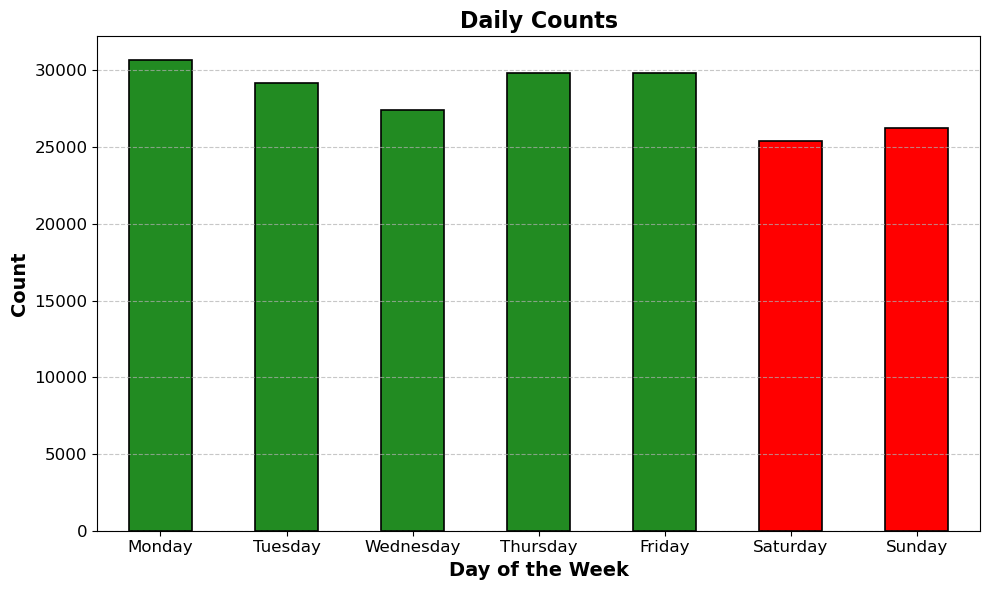

In [120]:
chat['day_of_week'] = chat['timestamp'].dt.dayofweek

# Count the occurrences of each day of the week
day_counts = chat['day_of_week'].value_counts().sort_index()

# Define colors for each day of the week
colors = []
for day in day_counts.index:
    if day in [5, 6]:  # Saturday and Sunday
        colors.append('red')  # Use a red color for Sat and Sun
    else:
        colors.append('forestgreen')  # Use a green color for other days

# Map day numbers to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts.index = day_names

# Plotting the vertical bar chart with custom colors
plt.figure(figsize=(10, 6))  # Set the figure size
day_counts.plot.bar(color=colors, edgecolor='black', linewidth=1.2)

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding labels and title with enhanced font properties
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=14, fontweight='bold')
plt.title('Daily Counts', fontsize=16, fontweight='bold')

# Customizing ticks
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


### month

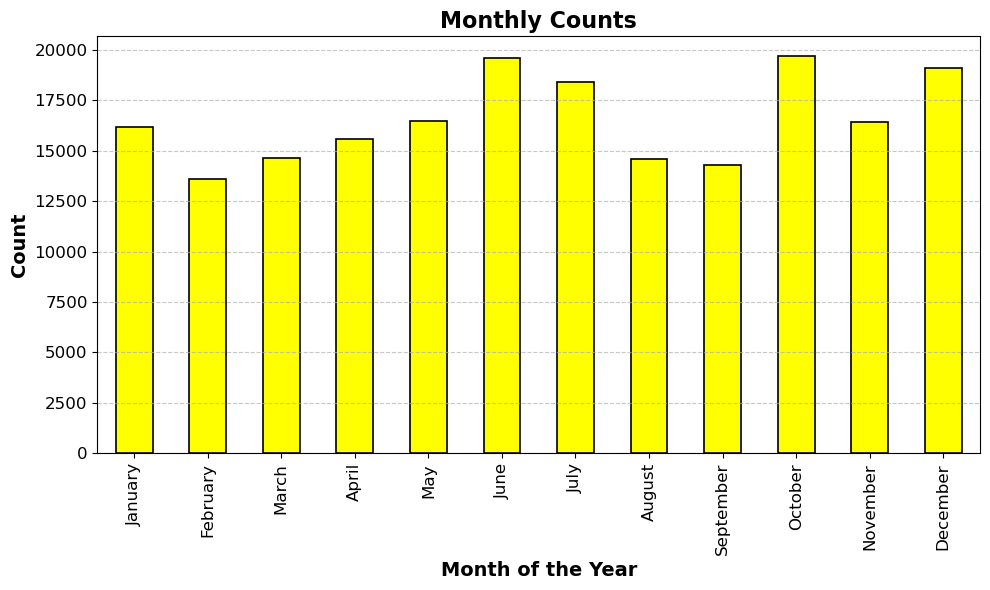

In [123]:
# Extract the month from the timestamp
chat['month'] = chat['timestamp'].dt.month

# Count the occurrences of each month
month_counts = chat['month'].value_counts().sort_index()

# Map month numbers to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_counts.index = month_names

plt.figure(figsize=(10, 6)) 
month_counts.plot.bar(color='yellow', edgecolor='black', linewidth=1.2)


plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xlabel('Month of the Year', fontsize=14, fontweight='bold')
plt.title('Monthly Counts', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  
plt.show()


### message type

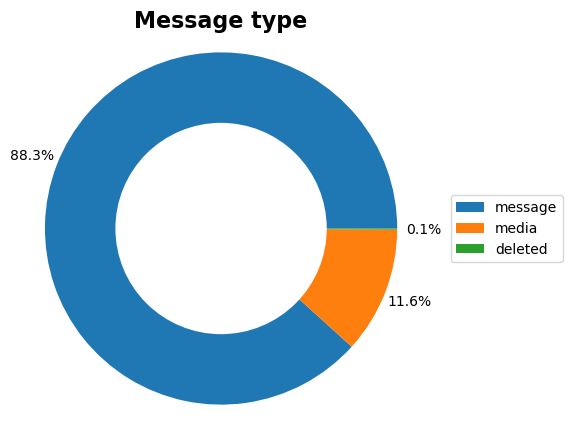

In [286]:
plt.figure(figsize=(5, 5))
plt.pie(message_type_counts['count'], 
        labels=None,  # No labels on the pie chart
        autopct='%1.1f%%',  # Show percentages
        pctdistance=1.15,  # Move percentages outside
        startangle=0)
plt.title('Frequency of Languages')

plt.legend(message_type_counts.index, 
           title='', 
           loc='center right',  
           bbox_to_anchor=(1.4, 0.5))

plt.axis('equal')

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Message type', fontsize=16, fontweight='bold')

plt.show()

### language

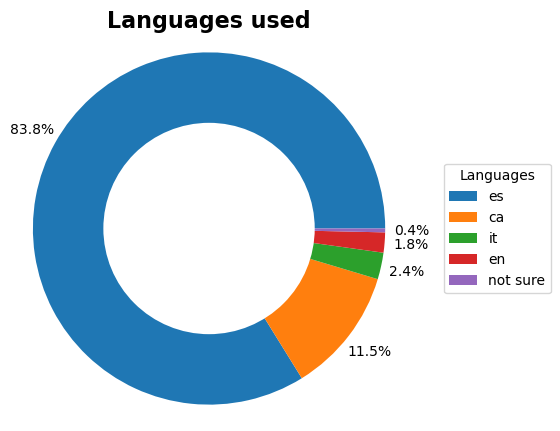

In [222]:
# Count the frequency of each language
language_counts = chat['language'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(language_counts, 
        labels=None,  # No labels on the pie chart
        autopct='%1.1f%%',  # Show percentages
        pctdistance=1.15,  # Move percentages outside
        startangle=0)
plt.title('Frequency of Languages')

plt.legend(language_counts.index, 
           title='Languages', 
           loc='center right',  
           bbox_to_anchor=(1.4, 0.5)) 

plt.axis('equal')

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Languages used', fontsize=16, fontweight='bold')

plt.show()


### monthly/weekly aggregated groups whit available data

In [46]:
# Group by 'contact' and 'year_month' and count unique combinations
months_with_data = chat.groupby(['contact', 'year_month']).size().reset_index(name='count')
number_of_groups = months_with_data.shape[0]

print(f'MONTHLY Analysis - Number of combinations (contact, year_month) with messages: {number_of_groups}')

MONTHLY Analysis - Number of combinations (contact, year_month) with messages: 260


In [47]:
# Group by 'contact' and 'year_mweek' and count unique combinations
months_with_data = chat.groupby(['contact', 'year_week']).size().reset_index(name='count')
number_of_groups = months_with_data.shape[0]

print(f'WEEKLY Analysis - Number of combinations (contact, year_week) with messages: {number_of_groups}')

WEEKLY Analysis - Number of combinations (contact, year_week) with messages: 1078


### chat info aggregated by month

In [128]:
monthly = chat.groupby(['contact', 'year_month']).agg(
    message_count=('message_id', 'count'),   
    month_share=('month_share', 'mean'),
    m_enm=('m_enm', 'mean'),
    stage=('stage', 'first'),  
    uptime=('uptime', 'mean'),
    media_ratio=('media_ratio', 'mean'),
    waiting_time=('waiting_time', 'mean'),
    sa_polarity=('sa_polarity', 'mean'),
    happiness=('happiness', 'mean')
).reset_index()


### chat info aggregated by week

In [129]:
weekly = chat.groupby(['contact', 'year_week']).agg(
    message_count=('message_id', 'count'),     
    week_share=('week_share', 'mean'),
    w_enm=('w_enm', 'mean'),
    stage=('stage', 'first'), 
    uptime=('uptime', 'mean'),
    media_ratio=('media_ratio', 'mean'),
    waiting_time=('waiting_time', 'mean'),
    sa_polarity=('sa_polarity', 'mean'),
    happiness=('happiness', 'mean'),
    ended =('ended', 'first')
).reset_index()


In [130]:
weekly_ended = weekly[weekly.ended == True]

## crosstab message count

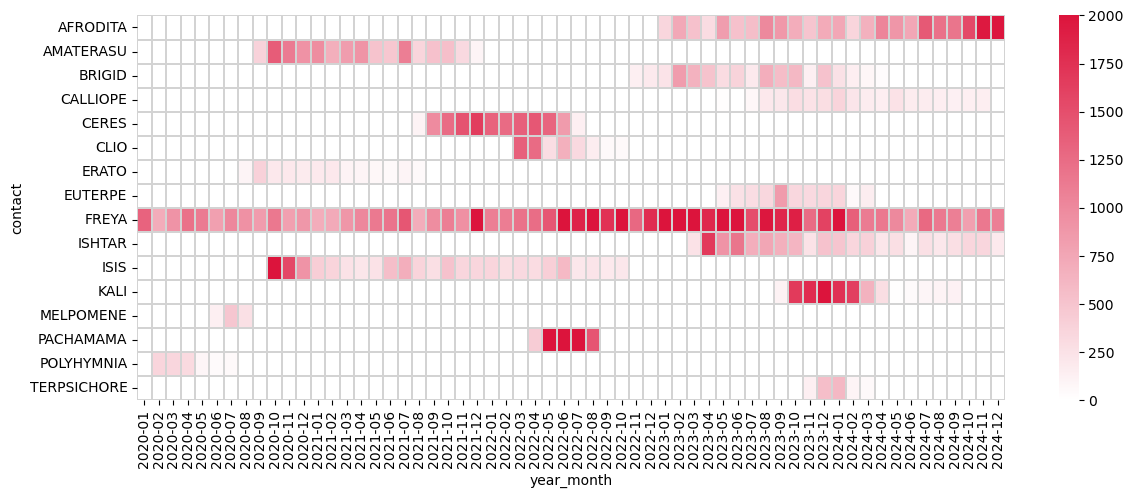

In [51]:
crosstab_message_count = pd.crosstab(chat['contact'], chat.year_month)

cmap = mcolors.LinearSegmentedColormap.from_list("custom_white_black", ["white", "crimson"])
plt.figure(figsize=(14, 5))
sns.heatmap(crosstab_message_count, annot=False, cmap=cmap, cbar=True, vmax=2000, linecolor='lightgrey', linewidths=0.05) 

plt.show()


### creation of a custom 16 color husl palette

<Figure size 1000x600 with 0 Axes>

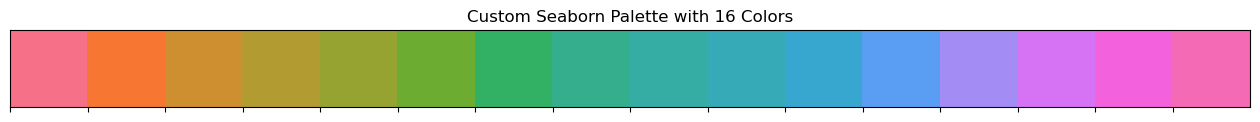

In [52]:
# Define a custom palette with 16 colors
custom_palette = sns.color_palette("husl", 16)

# Set the palette
sns.set_palette(custom_palette)

# Create a sample plot to visualize the palette
plt.figure(figsize=(10, 6))
sns.palplot(custom_palette)
plt.title("Custom Seaborn Palette with 16 Colors")
plt.show()

### correlation matrix

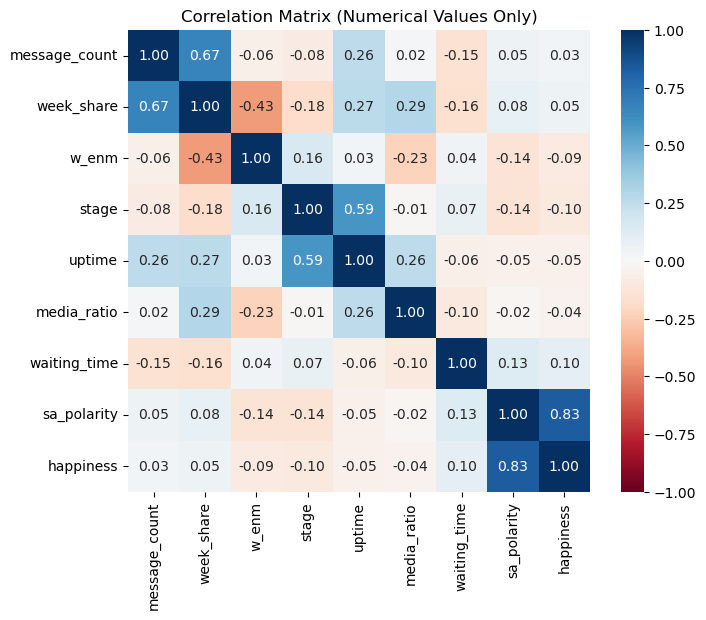

In [54]:
# Drop non-numeric columns
df_numeric = weekly.select_dtypes(include=[np.number])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f', square=True, vmax=1, vmin=-1)
plt.title('Correlation Matrix (Numerical Values Only)')
plt.show()

### sentiment adjusted value vs count of active counters (month granularity)

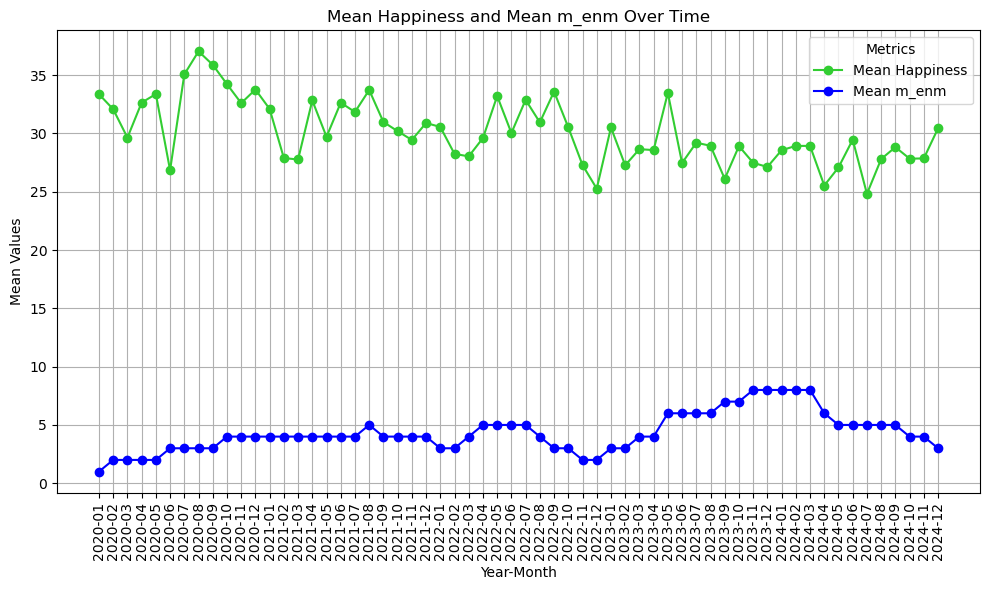

In [74]:
# Grouping by 'year_month' and calculating the mean for 'happiness' and 'm_enm'
mean_happiness = monthly.groupby('year_month')['happiness'].mean().reset_index()
mean_m_enm = monthly.groupby('year_month')['m_enm'].mean().reset_index()

# Creating the line graph
plt.figure(figsize=(10, 6))
plt.plot(mean_happiness['year_month'], mean_happiness['happiness'], marker='o', label='Mean Happiness', color='limegreen')
plt.plot(mean_m_enm['year_month'], mean_m_enm['m_enm'], marker='o', label='Mean m_enm', color='blue')

# Adding labels and title
plt.title('Mean Happiness and Mean m_enm Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)
plt.legend(title='Metrics')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


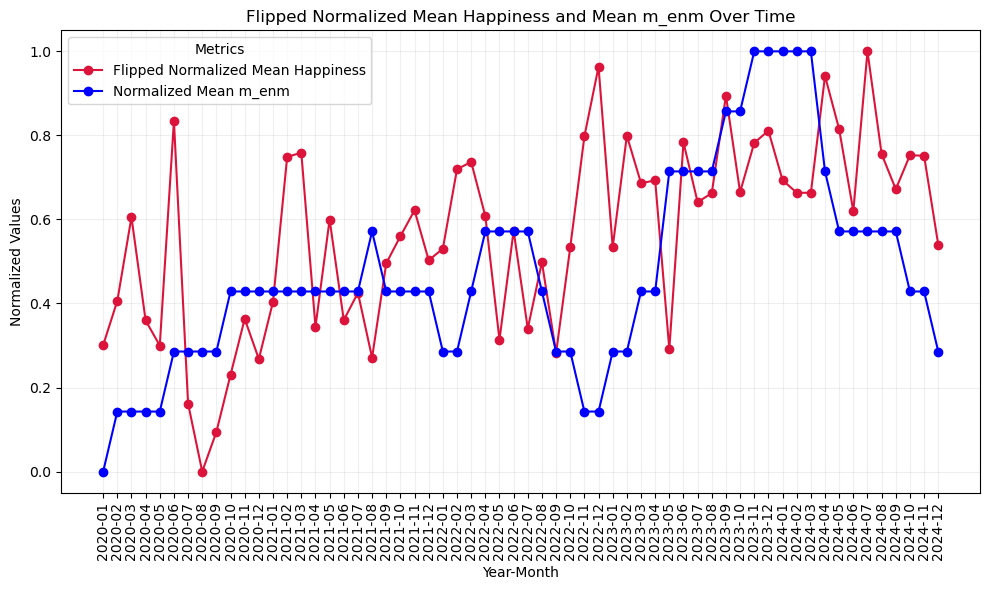

Correlation coefficient: -0.19283517646803916


In [77]:
# Grouping by 'year_month' and calculating the mean for 'happiness' and 'm_enm'
mean_happiness = monthly.groupby('year_month')['happiness'].mean().reset_index()
mean_m_enm = monthly.groupby('year_month')['m_enm'].mean().reset_index()

# Normalize the happiness values and flip them
happiness_min = mean_happiness['happiness'].min()
happiness_max = mean_happiness['happiness'].max()
mean_happiness['normalized_happiness'] = 1 - ((mean_happiness['happiness'] - happiness_min) / (happiness_max - happiness_min))

# Normalize the m_enm values
m_enm_min = mean_m_enm['m_enm'].min()
m_enm_max = mean_m_enm['m_enm'].max()
mean_m_enm['normalized_m_enm'] = (mean_m_enm['m_enm'] - m_enm_min) / (m_enm_max - m_enm_min)

# Creating the line graph
plt.figure(figsize=(10, 6))
plt.plot(mean_happiness['year_month'], mean_happiness['normalized_happiness'], marker='o', label='Flipped Normalized Mean Happiness', color='crimson')
plt.plot(mean_m_enm['year_month'], mean_m_enm['normalized_m_enm'], marker='o', label='Normalized Mean m_enm', color='blue')

plt.title('Flipped Normalized Mean Happiness and Mean m_enm Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Normalized Values')
plt.xticks(rotation=90)
plt.legend(title='Metrics')
plt.grid(True, alpha =0.2)
plt.tight_layout()

plt.show()

correlation = monthly['happiness'].corr(monthly['m_enm'])
print(f'Correlation coefficient: {correlation}')



### ratio of messages per contact for each month

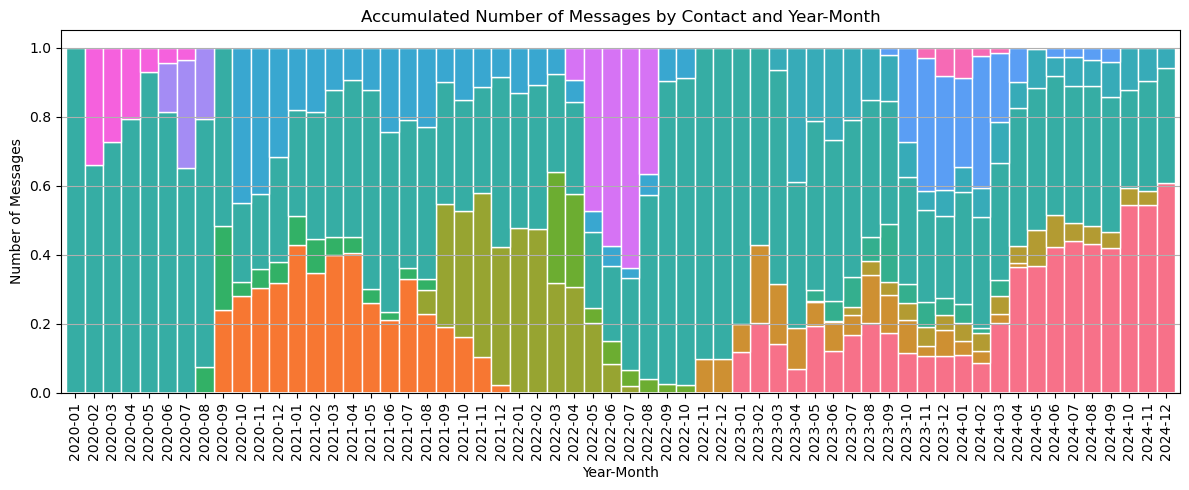

In [58]:
# Pivot the DataFrame to have 'year_month' as index and 'contact' as columns
pivoted = monthly.pivot(index='year_month', columns='contact', values='month_share').fillna(0)

pivoted = pivoted.sort_index()

# Plot the data as a stacked bar graph
ax = pivoted.plot(kind='bar', stacked=True, width=1, figsize=(12, 5), legend=False)

for container in ax.containers:
    for bar in container:
        bar.set_edgecolor('white')  
        bar.set_linewidth(1)  

plt.title('Accumulated Number of Messages by Contact and Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=90)  
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


### stacked count of messages (absolute value)


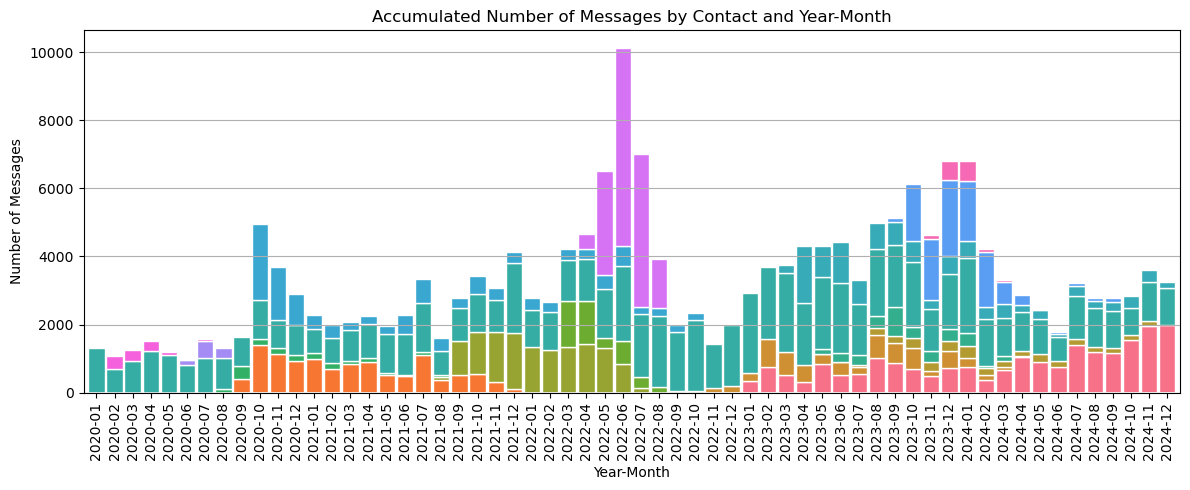

In [59]:
# Group by 'year_month' and 'contact' and count occurrences
grouped = chat.groupby(['year_month', 'contact']).size().reset_index(name='count')

# Pivot the DataFrame to have 'year_month' as index and 'contact' as columns
pivoted = grouped.pivot(index='year_month', columns='contact', values='count').fillna(0)

pivoted = pivoted.sort_index()

ax = pivoted.plot(kind='bar', stacked=True, width=0.9, figsize=(12, 5), legend=False)

for container in ax.containers:
    for bar in container:
        bar.set_edgecolor('white') 
        bar.set_linewidth(1)  

# Add titles and labels
plt.title('Accumulated Number of Messages by Contact and Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=90)  
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### mean number of messages, monthly granularity
Compared with an scaled evolution of active contacts

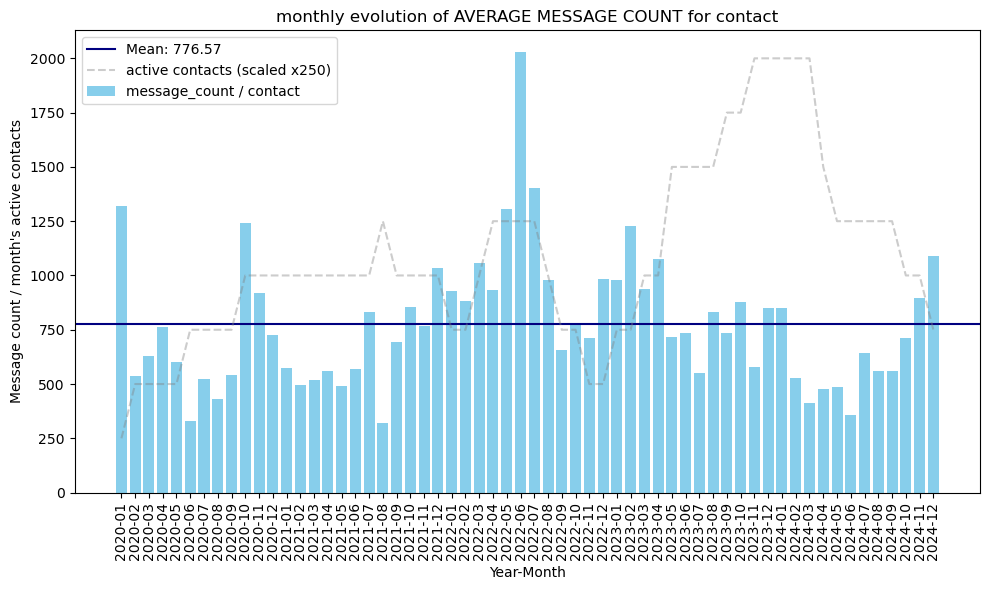

Correlation between average monthly messages per contact and active monthly contacts: -0.11


In [295]:
# Group by 'year_month' and count unique 'message_id'
count_df = chat.groupby('year_month')['message_id'].nunique().reset_index()

count_df = count_df.merge(chat[['year_month', 'm_enm']].drop_duplicates(), on='year_month')

# Calculate the ratio
count_df['ratio'] = count_df['message_id'] / count_df['m_enm']

# Calculate the mean of the ratios
mean_ratio = count_df['ratio'].mean()

# scale active contacts (x250)
count_df['m_enm_scaled'] = count_df['m_enm'] * 250

plt.figure(figsize=(10, 6))
bars = plt.bar(count_df['year_month'], count_df['ratio'], color='skyblue', label='message_count / contact')
plt.xlabel('Year-Month')
plt.ylabel("Message count / month's active contacts")
plt.title('monthly evolution of AVERAGE MESSAGE COUNT for contact')
plt.xticks(rotation=90)

plt.axhline(mean_ratio, color='navy', linestyle='-', label=f'Mean: {mean_ratio:.2f}')

plt.plot(count_df['year_month'], count_df['m_enm_scaled'], color='grey', linestyle='--', label='active contacts (scaled x250)', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the correlation
correlation = count_df['ratio'].corr(count_df['m_enm'])
print(f'Correlation between average monthly messages per contact and active monthly contacts: {correlation:.2f}')


## happiness distribution

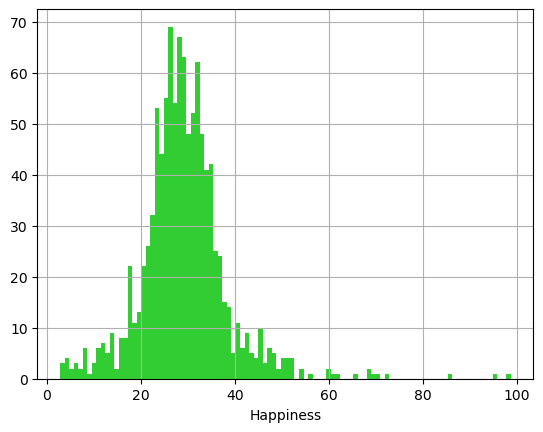

In [298]:
weekly.happiness.hist(bins=100, color='limegreen')
plt.xlabel("Happiness")
plt.show()

### Happiness vs share

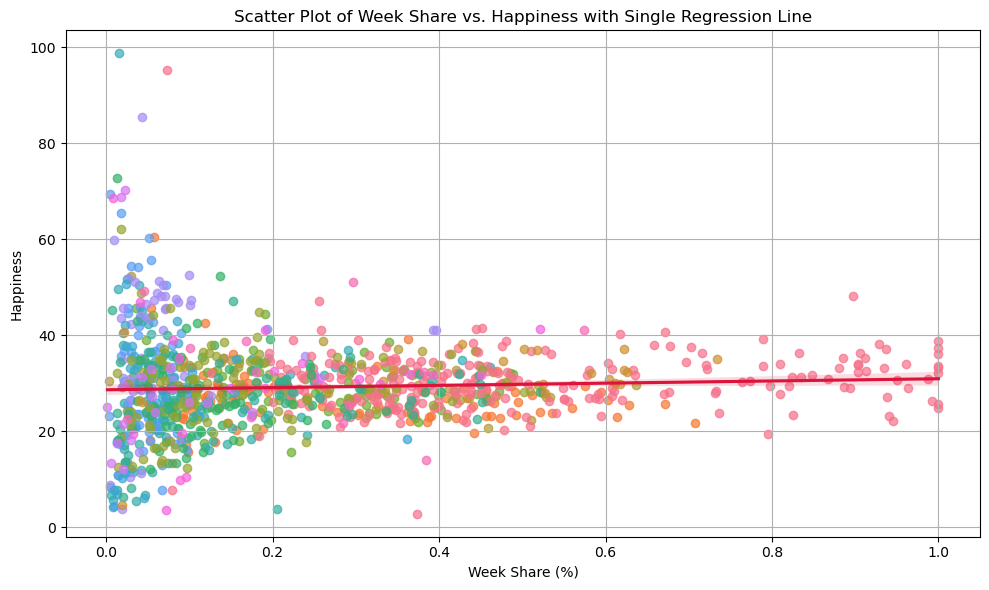

Correlation coefficient: 0.053687510149515526


In [136]:
# Generate a HUSL palette with 16 distinct colors
palette = sns.color_palette("husl", 16)

# Create a color mapping for each contact
color_mapping = {contact: palette[i] for i, contact in enumerate(contacts)}

plt.figure(figsize=(10, 6))

# Plot points with different colors based on contact
for contact in weekly['contact'].unique():
    subset = weekly[weekly['contact'] == contact]
    plt.scatter(subset['week_share'], subset['happiness'],  
                color=color_mapping[contact], alpha=0.7)

# regression line 
sns.regplot(data=weekly, x='week_share', y='happiness', 
            scatter=False, color='crimson', line_kws={'label': 'Regression Line'})

plt.title('Scatter Plot of Week Share vs. Happiness with Single Regression Line')
plt.xlabel('Week Share (%)')  
plt.ylabel('Happiness')       
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = weekly['week_share'].corr(weekly['happiness'])  
print(f'Correlation coefficient: {correlation}')


### ENM vs happiness

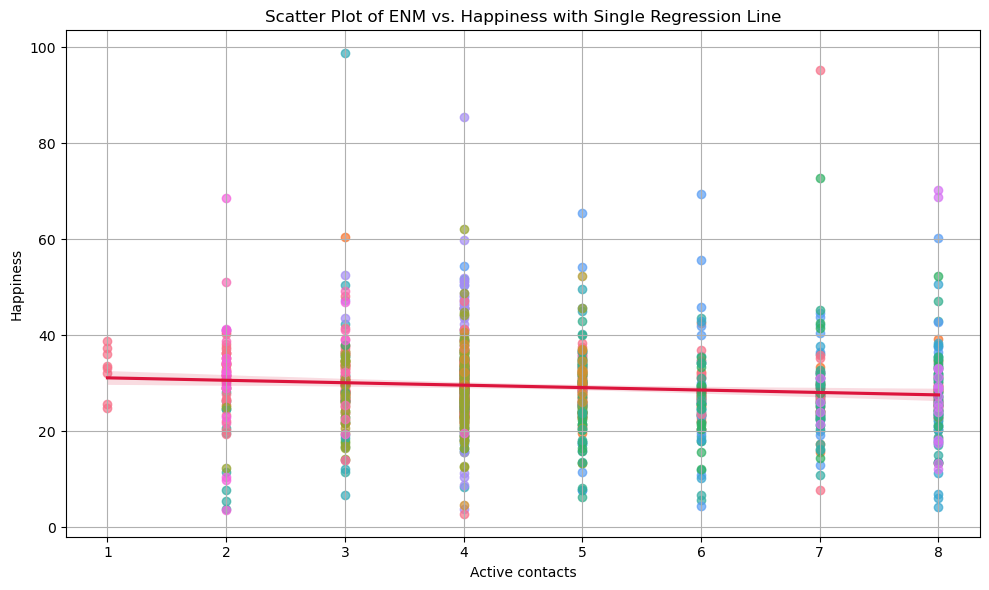

Correlation coefficient: -0.09338096741114454


In [299]:
# Generate a HUSL palette with 16 distinct colors
palette = sns.color_palette("husl", 16)

# Create a color mapping for each contact
color_mapping = {contact: palette[i] for i, contact in enumerate(contacts)}

plt.figure(figsize=(10, 6))

# Plot points with different colors based on contact
for contact in weekly['contact'].unique():
    subset = weekly[weekly['contact'] == contact]
    plt.scatter(subset['w_enm'], subset['happiness'], 
                color=color_mapping[contact], alpha=0.7)

# regression line
sns.regplot(data=weekly, x='w_enm', y='happiness', 
            scatter=False, color='crimson', line_kws={'label': 'Regression Line'})

plt.title('Scatter Plot of ENM vs. Happiness with Single Regression Line')
plt.xlabel('Active contacts')  
plt.ylabel('Happiness')      
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = weekly['w_enm'].corr(weekly['happiness']) 
print(f'Correlation coefficient: {correlation}')


### happiness vs stage

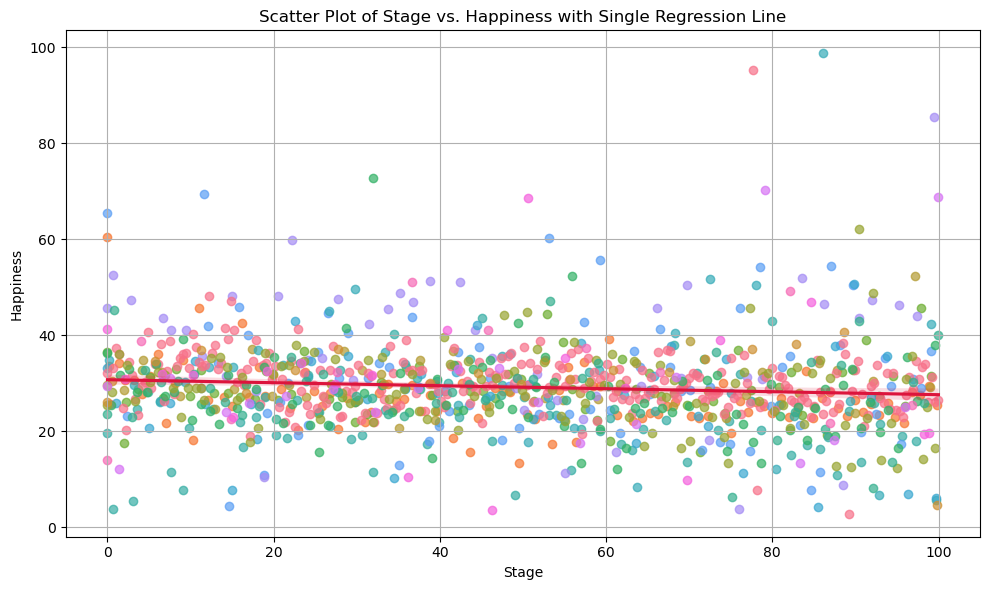

Correlation coefficient: -0.09617287121910012


In [137]:
# Generate a HUSL palette with 16 distinct colors
palette = sns.color_palette("husl", 16)

# Create a color mapping for each contact
color_mapping = {contact: palette[i] for i, contact in enumerate(contacts)}

# Creating the scatter plot with colors based on contact
plt.figure(figsize=(10, 6))

# Plot points with different colors based on contact
for contact in weekly['contact'].unique():
    subset = weekly[weekly['contact'] == contact]
    plt.scatter(subset['stage'], subset['happiness'],  
                color=color_mapping[contact], alpha=0.7)

sns.regplot(data=weekly, x='stage', y='happiness', 
            scatter=False, color='crimson', line_kws={'label': 'Regression Line'})

# Adding labels and title
plt.title('Scatter Plot of Stage vs. Happiness with Single Regression Line')
plt.xlabel('Stage')          
plt.ylabel('Happiness')      
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = weekly['stage'].corr(weekly['happiness'])  
print(f'Correlation coefficient: {correlation}')


### Happiness over time for a specific contact

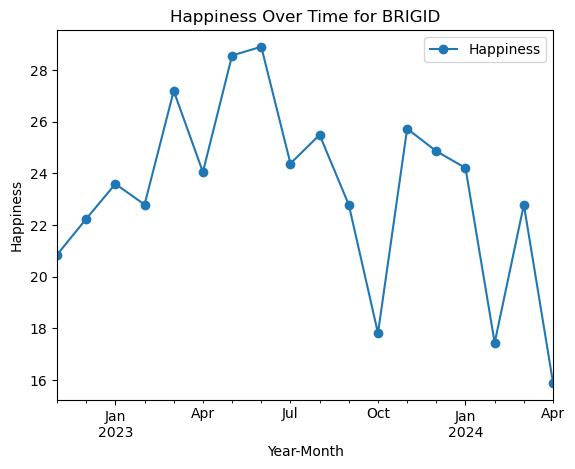

In [142]:
aggregated_df = monthly

# Filter the DataFrame for a specific contact
specific_contact = 'BRIGID'  # specific contact name
filtered_df = aggregated_df[aggregated_df['contact'] == specific_contact]

if filtered_df.empty:
    print(f"No data available for contact: {specific_contact}")
else:
    filtered_df['year_month'] = pd.to_datetime(filtered_df['year_month'])

    ax = filtered_df.plot(x='year_month', y='happiness', kind='line', marker='o', label='Happiness')

    plt.xlabel('Year-Month')
    plt.ylabel('Happiness')
    plt.title(f'Happiness Over Time for {specific_contact}')
    plt.legend()
    plt.show()


### messages over time for a specific contact

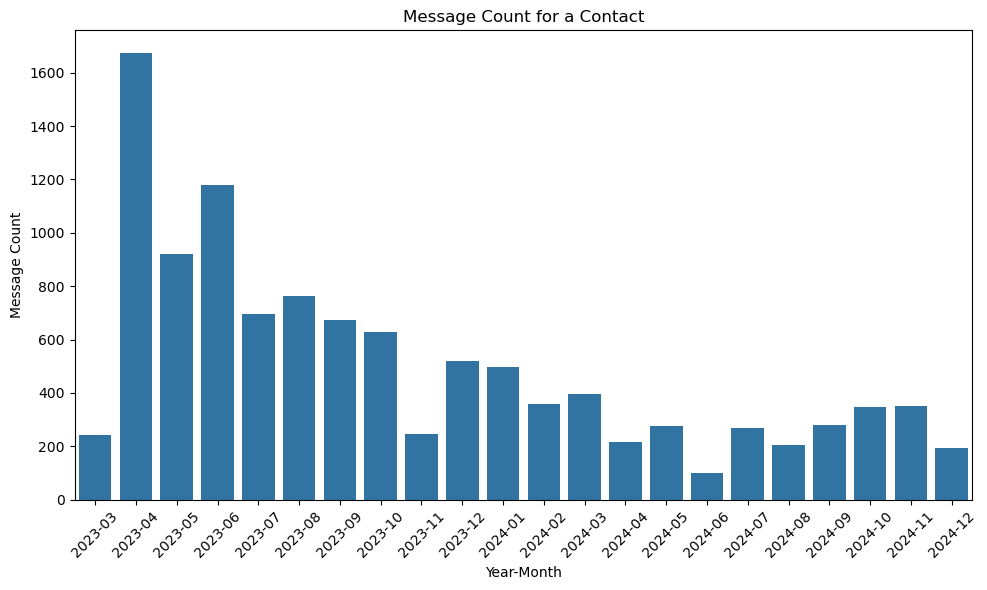

In [239]:
# Filter for the specific contact
filtered_data = monthly[monthly['contact'] == 'ISHTAR']

# Sort by 'year_week'
filtered_data = filtered_data.sort_values(by='year_month')


plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_data, x='year_month', y='message_count')

plt.title('Message Count for a Contact')
plt.xlabel('Year-Month')
plt.ylabel('Message Count')
plt.xticks(rotation=45)  y
plt.tight_layout()  
plt.show()


### Facetgrid - Message count over time (absolute time)

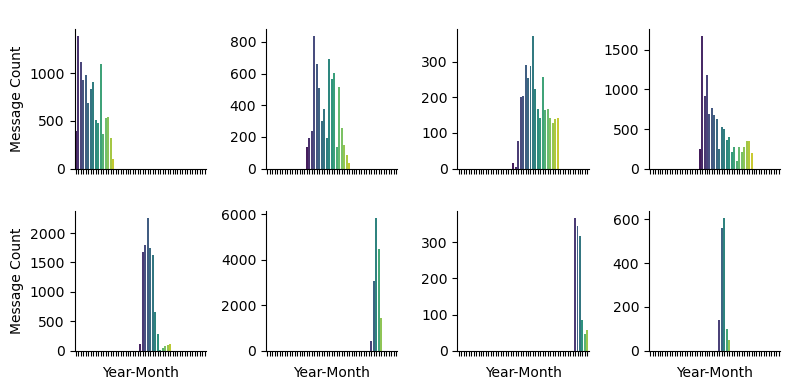

In [262]:
# Define the list of contacts to include
contacts_to_include = ['ISHTAR', 'AMATERASU', 'CALLIOPE', 'KALI', 'PACHAMAMA', 'POLYHYMNIA', 'BRIGID', 'BRIGID', 'TERPSICHORE']

# Filter the DataFrame for the specified contacts
filtered_monthly = monthly[monthly['contact'].isin(contacts_to_include)]

# Create the FacetGrid 
g = sns.FacetGrid(filtered_monthly, col='contact', col_wrap=4, height=2, sharey=False)

g.map_dataframe(sns.barplot, x='year_month', y='message_count', palette='viridis')

g.set_titles(col_template=" ")
g.set_axis_labels("Year-Month", "Message Count")
g.set_xticklabels(None) 

plt.tight_layout() 
plt.show()


### Facetgrid - message count over stage (normalized time)

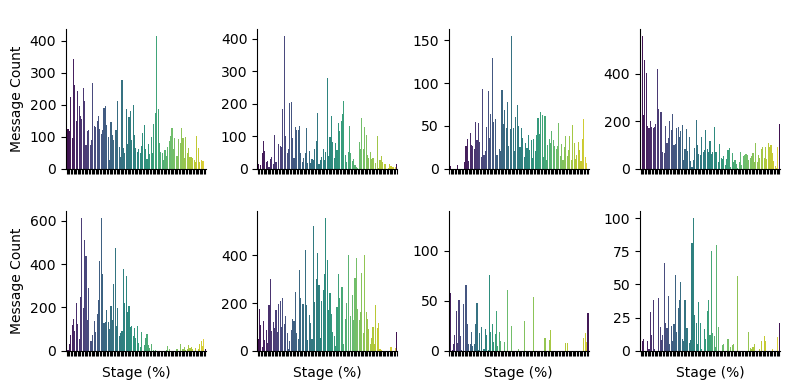

In [259]:
# Round the 'stage' column to the nearest integer
chat['stage'] = chat['stage'].round().astype(int)

# Filter the DataFrame for the specified contacts
filtered_chat = chat[chat['contact'].isin(contacts_to_include)]

stage_counts = filtered_chat.groupby(['contact', 'stage']).size().reset_index(name='message_count')

g = sns.FacetGrid(stage_counts, col='contact', col_wrap=4, height=2, sharey=False)
g.map_dataframe(sns.barplot, x='stage', y='message_count', palette='viridis')

# Add titles and labels
g.set_titles(col_template=" ")
g.set_axis_labels("Stage (%)", "Message Count")
g.set_xticklabels(None)  
plt.tight_layout()  
plt.show()


### boxplot waiting time for stage (grouped in 10% bins)

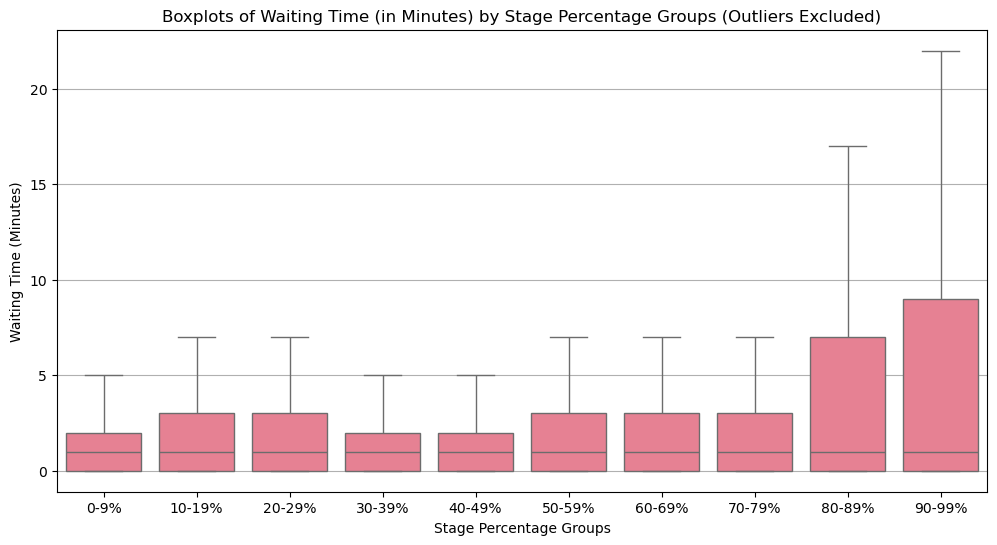

In [69]:
# Filter the DataFrame to include only messages where 'ended' is True
filtered_chat = chat[chat['ended'] == True]

# Create bins for the 'stage' column
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [f'{i}-{i+9}%' for i in range(0, 100, 10)]
filtered_chat['stage_group'] = pd.cut(filtered_chat['stage'], bins=bins, labels=labels, right=False)

# Convert waiting_time to minutes
filtered_chat['waiting_time_minutes'] = filtered_chat['waiting_time'].dt.total_seconds() / 60

plt.figure(figsize=(12, 6))
sns.boxplot(x='stage_group', y='waiting_time_minutes', data=filtered_chat, showfliers=False)
plt.title('Boxplots of Waiting Time (in Minutes) by Stage Percentage Groups (Outliers Excluded)')
plt.xlabel('Stage Percentage Groups')
plt.ylabel('Waiting Time (Minutes)')
plt.grid(axis='y')
plt.show()


### Mean message count by stage (i.e. over normalized time)

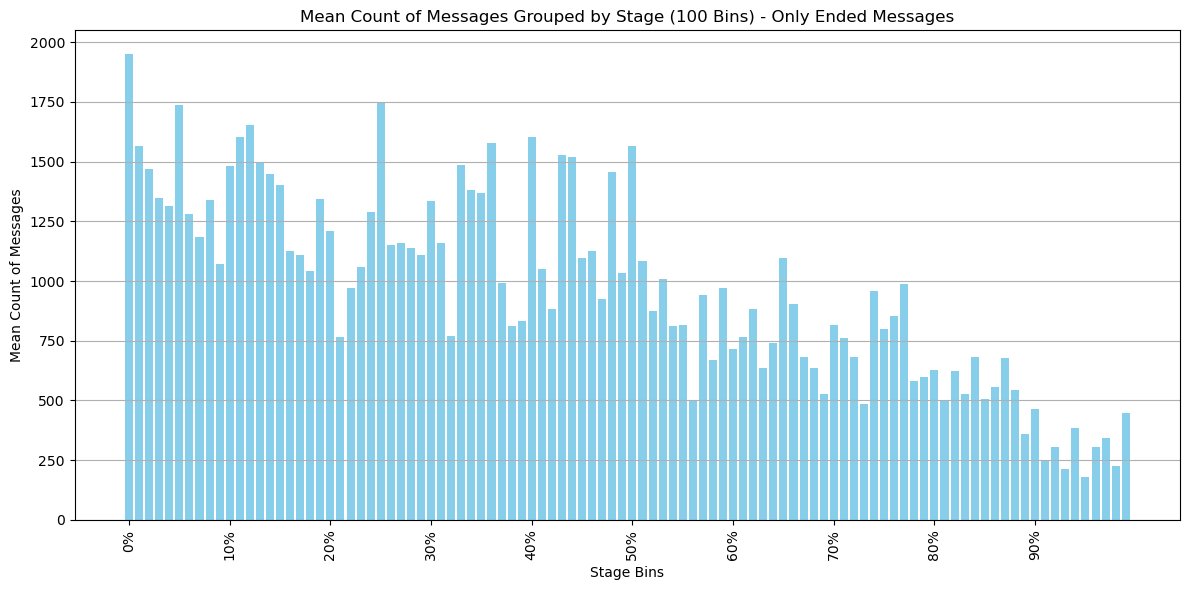

In [71]:
# Filter the DataFrame to include only messages where 'ended' is True
filtered_chat = chat[chat['ended'] == True]

bins = np.linspace(0, 100, 101)  # 100 bins from 0 to 100
filtered_chat['stage_bin'] = pd.cut(filtered_chat['stage'], bins=bins, include_lowest=True)

mean_counts = filtered_chat.groupby('stage_bin')['message_id'].count().reset_index()
mean_counts.columns = ['stage_bin', 'mean_count']

plt.figure(figsize=(12, 6))
plt.bar(mean_counts['stage_bin'].astype(str), mean_counts['mean_count'], color='skyblue')
plt.title('Mean Count of Messages Grouped by Stage (100 Bins) - Only Ended Messages')
plt.xlabel('Stage Bins')
plt.ylabel('Mean Count of Messages')

tick_positions = np.arange(0, len(mean_counts), 10)
tick_labels = [f'{int(bins[i])}%' for i in tick_positions] 

plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=90)  
plt.grid(axis='y')
plt.tight_layout()  
plt.show()


# EMOJI TIMELINE

#### top N emoji of the month

In [72]:
# emoji_df = pd.read_pickle('public/emoji10.pkl')

In [73]:
emoji_df.head(2)

,message_id,contact,timestamp,sender,emoji,emoji_count,year_month,year_week
4,5,FREYA,2020-01-01 01:05:00,FREYA,😊,1,2020-01,2020-W1
14,15,FREYA,2020-01-01 02:56:00,FREYA,😊,1,2020-01,2020-W1


In [74]:
def top_emoji_month(df):
    # Define a string of stop emojis
    stop_emojis = "☺"  # Add any emojis you want to exclude

    # Filter the DataFrame to only include rows where contact and sender are the same
    filtered_df = df[df['contact'] == df['sender']]

    # Create a list to store the top emojis for each row
    top_emojis_list = []

    # Group by contact and year_month
    grouped = filtered_df.groupby(['contact', 'year_month'])

    # Create a dictionary to store top emojis for each contact and month
    top_emojis_dict = {}

    for (contact, year_month), group in grouped:
        all_emojis = ''.join(group['emoji'])
        
        # Use emoji.emoji_list to get a list of all emojis
        emoji_list = [em['emoji'] for em in emoji.emoji_list(all_emojis)]
        
        # Filter out stop emojis
        filtered_emojis = [em for em in emoji_list if em not in stop_emojis]
        
        # Count freq for eache emoji
        emoji_counts = Counter(filtered_emojis)
        
        # Get the top 10 unique emojis ordered by their first appearance
        top_10 = [emoji for emoji, _ in emoji_counts.most_common(10)]
        
        top_emojis_string = ''.join(top_10)
        
        top_emojis_dict[(contact, year_month)] = top_emojis_string

    for index, row in df.iterrows():
        contact = row['contact']
        year_month = row['year_month']
        top_emojis = top_emojis_dict.get((contact, year_month), '')
        top_emojis_list.append(top_emojis)

    # Add the top emojis as a new column in the original DataFrame
    df['top_emoji_month'] = top_emojis_list
    
    return df


In [75]:
emoji_df = top_emoji_month(emoji_df)

In [86]:
# emoji_df.to_pickle("public/prueba_emoji.pkl")

## Concatenate emoji

In [ ]:
def concatenate_emojis(emoji_df, contact, year, top_n=None, separator=' '):
    # Filter the DataFrame for the specified contact and year
    filtered_df = emoji_df[
        (emoji_df['contact'] == contact) & 
        (emoji_df['year_month'].str.startswith(str(year)))
    ]
    
    # Group by year_month and take the first emoji string for each month
    grouped_df = filtered_df.groupby('year_month', as_index=False).first()
    
    # Ensure all values are strings before processing
    grouped_df['top_emoji_month'] = grouped_df['top_emoji_month'].astype(str)
    
    # If top_n is specified, slice the emoji string
    if top_n is not None:
        grouped_df['top_emoji_month'] = grouped_df['top_emoji_month'].apply(lambda x: x[:top_n])
    
    # Concatenate with specified separator
    concatenated_emojis = separator.join(grouped_df['top_emoji_month'].tolist())
    
    return concatenated_emojis

In [79]:
someone = getpass()
result = concatenate_emojis(emoji_df, someone, 2023, top_n=5)
print(result)  

 ········


😌😅🖤🤭😍 😌😔🥰🤭😅 😌🥰😬🤭😔 🥰🤭🖤😌😍 😌🤭🥰🖤😅 🤭😌🥰😅🖤 😌🤭🖤🥰😅 🤭😌😅🥰😍 🤭😅😌🤣🖤 😌🤭🥰😅🖤 🤭😔🥰😌🖤 🤭🥰🖤😌😅


In [85]:
someone = getpass()
result = concatenate_emojis(emoji_df, someone, 2023, top_n=5, separator='----')
print(result)  

 ········


😂😜😊🤪🤗----😂😜😘❤️----😂😜🤪❤️----😂😜😍🤪❤


In [87]:
someone = getpass()
result = concatenate_emojis(emoji_df, someone, 2022, top_n=6, separator="\n")
print(result)  

 ········


🤍🔥✨☺️😛
😛🤍😍✨🔥🥰
😍😛🤍🫶🔥😊
😛🤍😂😊😍🫶
😊🔥🤩🫶🤍😍


# BERTOPIC

In [3]:
# topic = pd.read_pickle('private/topic10.pkl')

## stopwords

In [ ]:
# Download the stopwords dataset
nltk.download('stopwords')

# Get the list of Spanish/English stopwords
spanish_stopwords = stopwords.words('spanish')
english_stopwords = stopwords.words('english')

# Combine the stopwords from both languages 
combined_stopwords = english_stopwords + spanish_stopwords

## bertopic to contact/year_month
models for each contact and year_month combination are stored inside a nested dictionary

In [5]:
ef contact_month_bertopic(messages):
    topic_model = BERTopic(language='multilingual', nr_topics=6, vectorizer_model=CountVectorizer(stop_words=combined_stopwords))
    topics, probs = topic_model.fit_transform(messages)
    return topic_model

def create_nested_dict(df):
    nested_dict = {}
    
    grouped = df.groupby(['contact', 'year_month'])
    
    for (contact, year_month), group in grouped:
        # If contact is not in the nested dictionary, add it
        if contact not in nested_dict:
            nested_dict[contact] = {}
        
        # Add the year_month and corresponding messages to the inner dictionary
        nested_dict[contact][year_month] = group['message'].tolist()
    
    return nested_dict

def transform_messages(nested_dict):
    transformed_dict = {}
    
    # Iterate over the outer dictionary
    for contact, year_months in nested_dict.items():
        transformed_dict[contact] = {}
        
        # Iterate over the inner dictionary
        for year_month, messages in year_months.items():
            # Apply the custom function to the list of messages
            print(f"Fitting to Bertopic: {contact} / {year_month}")
            transformed_dict[contact][year_month] = contact_month_bertopic(messages)
    
    return transformed_dict

In [6]:
# Loading only a range of time as sample
filtered_topic = topic[topic['year_month'].isin(['2022-05'])]

In [7]:
# Create the nested dictionary
nested_dict = create_nested_dict(filtered_topic)

# Transform the messages and store in a new nested dictionary
transformed_dict = transform_messages(nested_dict)

Fitting to Bertopic: CERES / 2022-05
Fitting to Bertopic: CLIO / 2022-05
Fitting to Bertopic: FREYA / 2022-05
Fitting to Bertopic: ISIS / 2022-05
Fitting to Bertopic: PACHAMAMA / 2022-05


In [8]:
# import pickle

In [9]:
# with open('bertopic10.pkl', 'wb') as file:
#    pickle.dump(transformed_dict, file)

## bertopic wordclouds

In [41]:
# Selecting a specific model from within the nested dictionary created
topic_model = transformed_dict['CERES']['2022-05']
# Get the topics and their words
topics = topic_model.get_topics()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create a word cloud for a specific topic
def create_wordcloud(topic_id, topic_words):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='winter').generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(2, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'Topic {topic_id}')
    plt.show()

# Loop through each topic and create a word cloud
for topic_id, words in topics.items():
    word_freq = {word: freq for word, freq in words}
    create_wordcloud(topic_id, word_freq)

***